# Autoencoders


## 1.0 Simple autoencoders on MNIST dataset 

For completeness this chapter is added. Chapter 2.0 is holds core idea of this project.

This short example will show couple use cases for autoencoders. It is necessary to show basic concepts on these examples to have a better understanding what is going on in our project (Chapter 2.0)

### 1.1 Additional functions used in the example:

In [ ]:
import matplotlib.pyplot as plt
import pandas as pandas
import numpy as np
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')

from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
from keras.regularizers import l1
from keras.optimizers import Adam
from keras.preprocessing import image


def plot_autoencoder_outputs(autoencoder, n, dims):
    decoded_imgs = autoencoder.predict(x_test)

    # number of example digits to show
    n = 5
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pandas.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pandas.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pandas.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()

### 1.2 Deep Autoencoder

Loading data, seperating data into train/test sets.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 784)
(10000, 784)


Defining the model,and training it.

In [ ]:
input_size = 784  
hidden_size = 128        #HYPERPARAM                      
code_size = 32           #HYPERPARAM

input_img = Input(shape=(input_size,))                            #INPUT LAYER
hidden_1 = Dense(hidden_size, activation='relu')(input_img)       #HIDDEN LAYER
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)            #HIDDEN LAYER
output_img = Dense(input_size, activation='sigmoid')(hidden_2)    #OUTPUT LAYER -> image

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')  #loss fn = HYPERPARAM

autoencoder.fit(x_train, x_train, epochs=3)                       #TRAINING

Epoch 1/3
1875/1875 [==============================] - 5s 1ms/step - loss: 0.1946
Epoch 2/3
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1036
Epoch 3/3
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0963


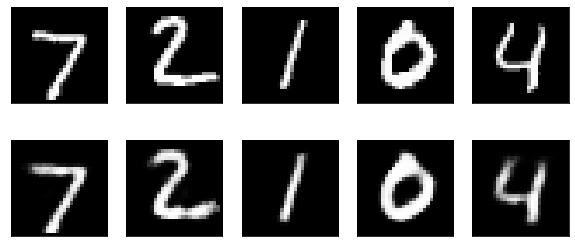

In [ ]:
plot_autoencoder_outputs(autoencoder, 5, (28, 28))

### 1.3 Shallow Autoencoder

We can make it very powerful by increasing the number of layers, nodes per layer and the code size. 

Increasing these hyperparameters will let the autoencoder to learn more complex codings. 

We should be careful otherwise the autoencoder will learn to copy its inputs to the output, without learning any meaningful representation. 
The autoencoder will reconstruct the training data, but it will be overfitting without being able to generalize to new instances, which is not what we want.

This is why we deliberately keep the code size small.

In [ ]:
input_size = 784
code_size = 32      #HYPERPARAM

input_img = Input(shape=(input_size,))                    
code = Dense(code_size, activation='relu')(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2247
Epoch 2/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1074
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0969
Epoch 4/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0953
Epoch 5/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0946


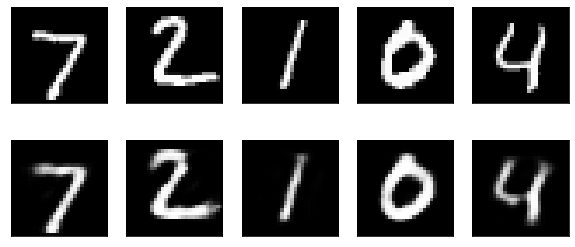

In [ ]:
plot_autoencoder_outputs(autoencoder, 5, (28, 28))

### 1.4 Denoising Autoencoder

Input to the model are noisy version of images
 (look the arguments of fit() function)

Keeping the code layer small forced our autoencoder to learn a good representation of the data. There is another way to force the autoencoder to learn useful features, which is adding random noise to its inputs.

This way the autoencoder can’t simply copy the input to its output because the input also contains random noise. 

We are asking it to subtract the noise and produce the underlying meaningful data. This is called a denoising autoencoder.

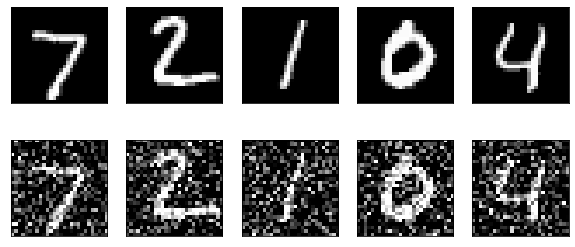

In [ ]:
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)



n = 5
plt.figure(figsize=(10, 4.5))
for i in range(n):
    # plot original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')

In [ ]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))                           #INPUT LAYER
hidden_1 = Dense(hidden_size, activation='relu')(input_img)       
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train, epochs=10)                 #TRAINING

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.2123
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1314
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1228
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1185
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1162
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1140
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1126
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1115
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1110
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1104


In [ ]:
len(x_train_noisy)

60000

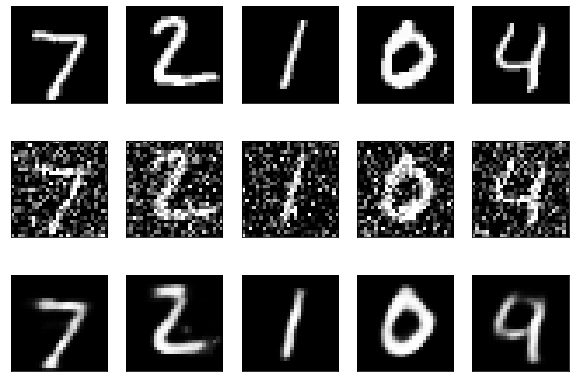

In [ ]:
n = 5
plt.figure(figsize=(10, 7))

images = autoencoder.predict(x_test_noisy)

for i in range(n):
    # plot original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')
        
    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Autoencoder Output')

### 1.5 Sparse autoencoders

Code layer is the only hidden layer in this model,with and without l1 regularization.

This method is using regularization. 

We can regularize the autoencoder by using a sparsity constraint such that only a fraction of the nodes would have nonzero values, called active nodes.
We add a penalty term to the loss function such that only a fraction of the nodes become active. 

In [ ]:
input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu')(input_img)           #ONLY HIDDEN LAYER
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder_standard = Model(input_img, output_img)
autoencoder_standard.compile(optimizer='adam', loss='binary_crossentropy')
history_standard = autoencoder_standard.fit(x_train, x_train, epochs=20)

encoded_standard = Model(input_img, code)

Epoch 1/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2234
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1092
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0971
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0953
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0945
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0943
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0943
Epoch 8/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0940
Epoch 9/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0939
Epoch 10/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0939
Epoch 11/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0938
Epoch 12/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0935
E

In [ ]:
input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu', activity_regularizer=l1(10e-6))(input_img)    #ONLY HIDDEN LAYER, BUT WITH l1 regularisation
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder_regularized = Model(input_img, output_img)
autoencoder_regularized.compile(optimizer='adam', loss='binary_crossentropy')
history_regularized = autoencoder_regularized.fit(x_train, x_train, epochs=20)

encoded_regularized = Model(input_img, code)

Epoch 1/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2242
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1098
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0992
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0976
Epoch 5/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0967
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0964
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0960
Epoch 8/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0959
Epoch 9/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0957
Epoch 10/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0953
Epoch 11/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0953
Epoch 12/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0951
E

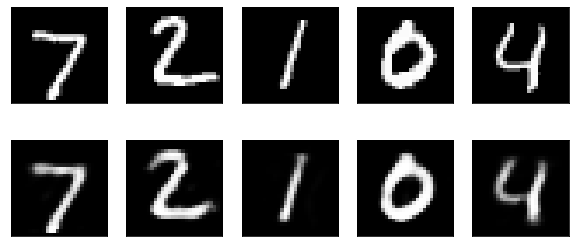

In [ ]:
plot_autoencoder_outputs(autoencoder_regularized, 5, (28, 28))

In [ ]:
autoencoder_standard.evaluate(x_test, x_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0922


0.09219779819250107

In [ ]:
autoencoder_regularized.evaluate(x_test, x_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0935


0.09347522258758545

## 2.0 Using auto-encoders to enhance the resolution of images on face image dataset (UI project)

We’ll try to enhance the resolution of images by training a convolution neural network and using auto-encoders 

Auto-encoders are a type of generative models used for unsupervised learning

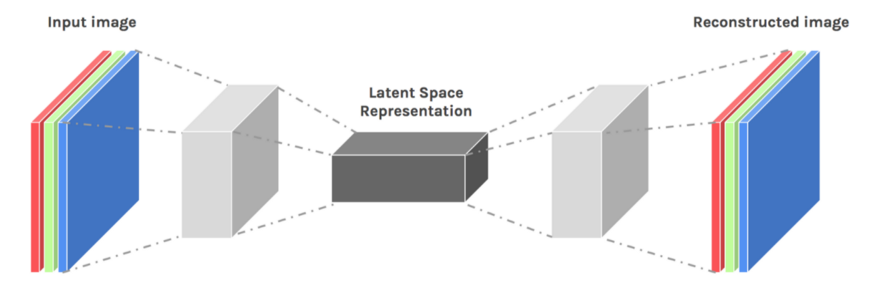

These models take input x, try to learn some features and then reconstruct input x to give some output X with the help of these learned features.
Concept of auto-encoder model will be used to increase the resolution of an image.

In [ ]:
# CODE USED FOR UNZIPING .zip FILE WITH IMAGES
#import zipfile
#with zipfile.ZipFile('lfw.zip', 'r') as zip_ref:
#    zip_ref.extractall('/content/drive/My Drive/PyData')

### Setting up working directory

This is necesarry ,to show Tenserflow where out data is.Alterative is to use Keras's implemeted function that download these data automaticaly.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/PyData

/content/drive/My Drive/PyData


### Library Imports

In [ ]:
import numpy as np
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pickle

### Importing Dataset

‘Labeled Faces in the Wild Home’ dataset is used. This dataset contains a database of labelled faces, used for face recognition. So we need to extract 
them from their folders.

Dataset link:
http://vis-www.cs.umass.edu/lfw/lfw.tgz

The dataset is organised in hierarchy ,we need to extract them and put them  to a single variable as an array. 

In [ ]:
face_images = glob.glob('lfw/**/*.jpg') #returns path of images

print(len(face_images)) #contains 13233 images

13233


### Loading and Preprocessing Images  (SKIP STEP IF DONE IN THE PAST)

The size of original images are of 250 x 250 pixels. 
Reduction in size is needed to 80 x 80 pixels because it saves a lot of power and time.

In [ ]:
#CODE ALREADY USED ONCE AND SAVED INTO VARIABLE 'face_images_path.pickle' USING PICKLE

#with open('face_images_path.pickle','wb') as f:
#  pickle.dump(face_images,f)

In [ ]:
#CHECKING 

print(len(face_images))

13233


These images will be processed using multiprocessing library tqdm.
tqdm is a progress library that we use to get a progress bar.

In [ ]:
from tqdm import tqdm         #A progess library

In [ ]:
#CODE ALREADY USED ONCE AND SAVED INTO VARIABLE 'img_array.pickle' USING PICKLE
 
from multiprocessing import Pool
progress = tqdm(total= len(face_images), position=0)
def read(path):
  img = image.load_img(path, target_size=(80,80,3))
  img = image.img_to_array(img)
  img = img/255.
  progress.update(1)
  return img

p = Pool(5)
img_array = p.map(read, face_images)

 20%|██        | 2648/13233 [09:21<54:23,  3.24it/s]

This array of processed images is now saved on drive using pickle:

In [ ]:
with open('img_array.pickle','wb') as f:
  pickle.dump(img_array, f)

In [ ]:
len(img_array)

13233

### Loading and Preprocessing Images (USE THIS SAVED VARIABLES IF ALREADY DID PREVIOUS STEP )

  Data:

  face_images: 250 x 250 pixel images
  
  img_array:   80 x 80   pixel images


In [ ]:
#READING FROM SAVED FILE 

with open('face_images_path.pickle','rb') as f:
  face_images = pickle.load(f)

with open('img_array.pickle','rb') as f:
  img_array = pickle.load(f)

In [ ]:
len(face_images)

13233

In [ ]:
len(img_array)

13233

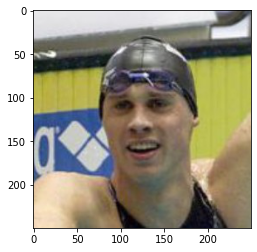

In [ ]:
#ORIGINAL:

plt.imshow(image.load_img(face_images[110]))

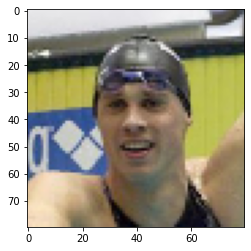

In [ ]:
#LOW RES. VERSION -> WILL BE USED AS INPUT DATA

plt.imshow(img_array[110])

### Data preparation for Model Training

We will split our dataset to train and validation set.

In [ ]:
all_images = np.array(img_array)

In [ ]:
#Split test and train data. all_images will be our output images
train_x, val_x = train_test_split(all_images, random_state = 32, test_size=0.2)

IMPORTANT STEP:
We will compress our images -> they will be our input. 

The original images  -> output images.

We will make input images by lowering resolution without changing the size

In [ ]:
#Function pixelates an image -> returns image of same size and lower res.

def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)

  low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

  return low_res_image



Train set  -> pixalate_image() -> Pixelated image TRAIN SET

Vali. set  -> pixalate_image() -> Pixelated image VALI. SET

In [ ]:
train_x_px = []

for i in range(train_x.shape[0]):
  temp = pixalate_image(train_x[i,:,:,:])
  train_x_px.append(temp)

train_x_px = np.array(train_x_px)  #Pixelated image TRAIN SET


# get low resolution images for the validation set
val_x_px = []

for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:])
  val_x_px.append(temp)

val_x_px = np.array(val_x_px)     #Pixelated image TRAIN SET

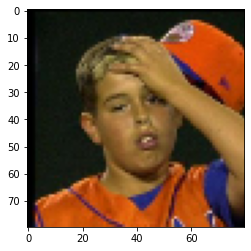

In [ ]:

plt.imshow(train_x[100])

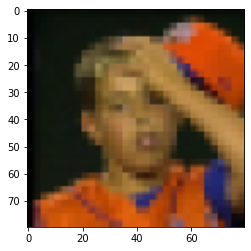

In [ ]:
plt.imshow(train_x_px[100])

### Model building (more advanced model is used for best results)

Definition of our model follows.

    What are Dense layers and when are they useful?
    Dense layers are used when association can exist among any feature to 
    any other feature in data point. 

Why do we use Conv2D layers instead of Dense layers?

    These are important when nearby associations among the features matter, 
    example object detection. 
    Neighborhoods matter to classify or detect. 
    It is very less likely that the pixels at the opposite corners(very far 
    away) are somehow helpful in these use cases. 
    Filters does this job of getting associations among neighborhoods.

Why do we use Max pooling layers?

    In Max pooling we choose the maximum value within a matrix. 
    It is basically used to reduce the size of the image because the larger 
    number of pixels contribute to more parameters which can involve large 
    chunks of data. So we need less parameters such that a CNN can still 
    identify the image.
    With max pooling size of the resulting image gets reduced and also 
    retaining the image information.

Why do we use padding='same' in convolution layers?

    Since convolution gives a smaller matrix at the output, padding is used
    on input matrix so when we convolute the matrix ,dimension stays the same
    durring the process.If we really want a smaller matrix, there are more
    refined ways to do it.

In [ ]:
Input_img = Input(shape=(80, 80, 3))  
    
#encoding architecture
x1 = Conv2D(64,  (3, 3),      activation='relu', padding='same')(Input_img)
x2 = Conv2D(64,  (3, 3),      activation='relu', padding='same')(x1)
x3 = MaxPool2D(                                  padding='same')(x2)
x4 = Conv2D(128, (3, 3),      activation='relu', padding='same')(x3)
x5 = Conv2D(128, (3, 3),      activation='relu', padding='same')(x4)
x6 = MaxPool2D(                                  padding='same')(x5)

encoded = Conv2D(256, (3, 3), activation='relu', padding='same')(x6)

# decoding architecture
x7 = UpSampling2D()(encoded)
x8 = Conv2D(128, (3, 3),      activation='relu', padding='same')(x7)
x9 = Conv2D(128, (3, 3),      activation='relu', padding='same')(x8)
x10 = Add()([x5, x9])

x11 = UpSampling2D()(x10)
x12 = Conv2D(64, (3, 3),      activation='relu', padding='same')(x11)
x13 = Conv2D(64, (3, 3),      activation='relu', padding='same')(x12)
x14 = Add()([x2, x13])

decoded = Conv2D(3, (3, 3),   activation='relu', padding='same')(x14)
 
autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
Input_img = Input(shape=(80, 80, 3))  
    
#encoding architecture
x1 = Conv2D(32,  (3, 3),      activation='relu', padding='same')(Input_img)

encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(x1)

# decoding architecture
x8 = Conv2D(32, (3, 3),      activation='relu', padding='same')(encoded)

decoded = Conv2D(3, (3, 3),   activation='relu', padding='same')(x8)
 
autoencoderE = Model(Input_img, decoded)
autoencoderE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


### Summary of our model

In [ ]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 80, 80, 64)   36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 40, 40, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
autoencoderE.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 80, 80, 32)        896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 80, 80, 16)        4624      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 80, 80, 32)        4640      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 80, 80, 3)         867       
Total params: 11,027
Trainable params: 11,027
Non-trainable params: 0
_________________________________________________________________


### Model Training

Defining some additional settings for our model:

Model checkpoint will save the model metadata after every epoch. In a case when training requires several days of time ,it is pretty obvious why this is a useful setting.

Early stopper acts as a break .Model constantly checks after every epoch , using validation set, if we somehow started overfitting it. If that is the case,
training will stop at that point ,the point where acurracy on the test set is highest.

In [ ]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=1, mode='min')

model_checkpoint = ModelCheckpoint('superResolution_checkpoint3.h5',save_best_only=True)

Training the more accurate model:

In [ ]:
history = autoencoder.fit(train_x_px,train_x,
            epochs=50,
            validation_data=(val_x_px, val_x),
            callbacks=[early_stopper, model_checkpoint],batch_size=256)

Epoch 1/50
42/42 [==============================] - 29s 691ms/step - loss: 0.0021 - accuracy: 0.9278 - val_loss: 0.0021 - val_accuracy: 0.9279
Epoch 2/50
42/42 [==============================] - 29s 701ms/step - loss: 0.0021 - accuracy: 0.9282 - val_loss: 0.0021 - val_accuracy: 0.9266
Epoch 3/50
42/42 [==============================] - 30s 709ms/step - loss: 0.0021 - accuracy: 0.9280 - val_loss: 0.0021 - val_accuracy: 0.9277
Epoch 4/50
42/42 [==============================] - 30s 715ms/step - loss: 0.0021 - accuracy: 0.9282 - val_loss: 0.0021 - val_accuracy: 0.9241
Epoch 5/50
42/42 [==============================] - 30s 720ms/step - loss: 0.0021 - accuracy: 0.9285 - val_loss: 0.0021 - val_accuracy: 0.9237
Epoch 6/50
42/42 [==============================] - 30s 726ms/step - loss: 0.0021 - accuracy: 0.9273 - val_loss: 0.0021 - val_accuracy: 0.9266
Epoch 7/50
42/42 [==============================] - 30s 727ms/step - loss: 0.0020 - accuracy: 0.9273 - val_loss: 0.0021 - val_accuracy: 0.9263

Training our more simple model:

In [ ]:
historyE = autoencoderE.fit(train_x_px,train_x,
            epochs=5,
            validation_data=(val_x_px, val_x))

### Save/Load model

In [ ]:
To save both models od disk drive, use this function:

In [ ]:
#autoencoder.save('path')
#autoencoder.save('pathE')

INFO:tensorflow:Assets written to: path/assets


To load models from drive ,use load_model function:

In [ ]:
autoencoder = tf.keras.models.load_model('path')
autoencoderE = tf.keras.models.load_model('pathE')

This function is not necesarry. It can be used when we are in the process   of training. 

    So when training takes long time, checkpoint is used to resume the training process.

In [ ]:
autoencoder = tf.keras.models.load_model('superResolution_checkpoint3.h5')

### Make Predictions

    Predictions are made on a pixelated versions of the validation set.
    Both models are compared.

In [ ]:
predictions1 = autoencoderE.predict(val_x_px)   #predict function of easier trained model

In [ ]:
predictions2 = autoencoder.predict(val_x_px)  #predict function of more advanced trained model

    Top row is the input : pixelated versions of the validation set
    2nd row is prediction of our simple model
    3rd row is prediction of the more complex model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


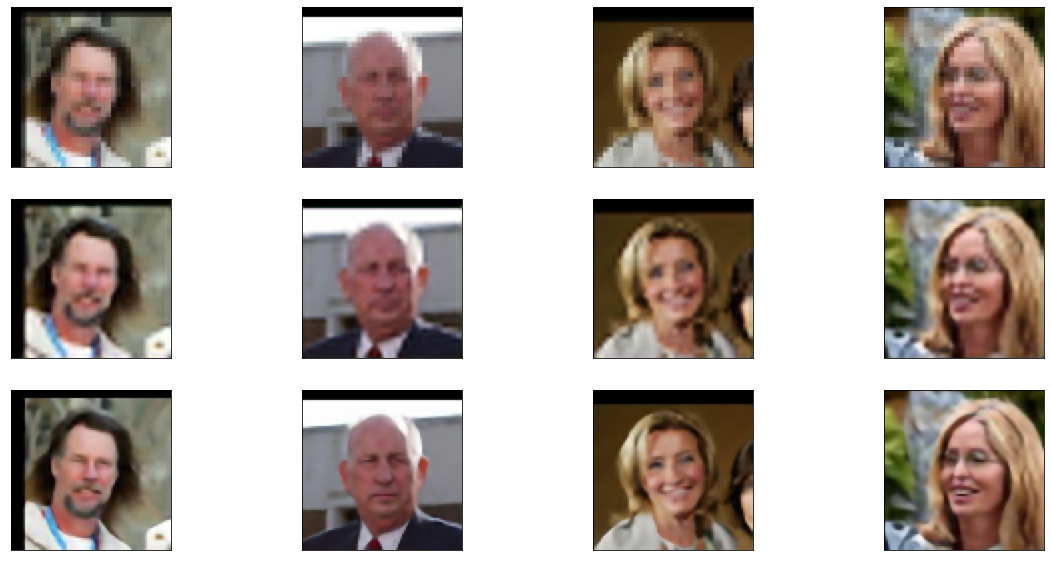

In [ ]:
n = 4
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(val_x_px[i+50])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(predictions1[i+50])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, i+1+n+n)
  plt.imshow(predictions2[i+50])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


plt.show()

Now comes the evaluation.
Using evaluate function, accuracy and loss over entire set is shown ,for each of the models.

You can see that even though there is a difference in accuracy in just 2 percent, images are drasticaly different.

In [ ]:
results = autoencoder.evaluate(val_x_px, val_x)
print('loss, accuracy', results)

results2 = autoencoderE.evaluate(val_x_px, val_x)
print('loss, accuracy', results2)

83/83 [==============================] - 3s 28ms/step - loss: 0.0021 - accuracy: 0.9260
loss, accuracy [0.0021005563903599977, 0.9260149002075195]
83/83 [==============================] - 1s 6ms/step - loss: 0.0035 - accuracy: 0.8728
loss, accuracy [0.003524225438013673, 0.8728340268135071]


### Reference material used in the project

Classification Tensorflow example:

https://www.tensorflow.org/tutorials/keras/classification


Keras overview:

https://www.tutorialspoint.com/keras/keras_overview_of_deep_learning.htm

https://towardsdatascience.com/introduction-to-keras-part-one-data-loading-43b9c015e27c

CNN guide:

https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

Loss-functions lecture for auto-encoders:

https://www.youtube.com/watch?v=xTU79Zs4XKY

Auto encoders:

https://towardsdatascience.com/applied-deep-learning-part-1-artificial-neural-networks-d7834f67a4f6#04e7

https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

https://towardsdatascience.com/image-super-resolution-using-convolution-neural-networks-and-auto-encoders-28c9eceadf90

https://medium.com/analytics-vidhya/super-resolution-using-autoencoders-and-tf2-0-505215c1674

Super resolution lecture:

https://www.youtube.com/watch?v=nG3tT31nPmQ



